# Exploratory Data Analysis (EDA)

This notebook performs a structured EDA on the dataset located in the project folder

## Objectives
1. Load data safely
2. Perform data quality checks
3. Summarize numeric & categorical variables
4. Explore outliers, distributions & correlations
5. Export a clean dataset for modeling


In [15]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize

# Download NLTK resources
nltk.download('punkt')
nltk.download('stop_words')
nltk.download('wordnet')
# Set visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)





[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading stop_words: Package 'stop_words' not found
[nltk_data]     in index
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Data Loading and Initial Inspection

In [53]:
# Business Understanding Context
print("""

DATA UNDERSTANDING:
- tweet_text: Raw tweet text (our primary feature).
- emotion_in_tweet_is_directed_at: The brand/product mentioned (Apple, Google, etc.). THIS IS OUR FIRST TARGET.
- is_there_an_emotion_directed_at_a_brand_or_product: The sentiment. THIS IS OUR SECOND TARGET.
""")



DATA UNDERSTANDING:
- tweet_text: Raw tweet text (our primary feature).
- emotion_in_tweet_is_directed_at: The brand/product mentioned (Apple, Google, etc.). THIS IS OUR FIRST TARGET.
- is_there_an_emotion_directed_at_a_brand_or_product: The sentiment. THIS IS OUR SECOND TARGET.



In [16]:
#loading dataset
df = pd.read_csv('judge_1377884607_tweet_product_company.csv')
# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumns and Data Types:")
print(df.dtypes)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (8721, 3)

Columns and Data Types:
tweet_text                                            object
emotion_in_tweet_is_directed_at                       object
is_there_an_emotion_directed_at_a_brand_or_product    object
dtype: object

First 5 rows:


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


# 1. Dataset Overview

In [54]:

# 1. Check for missing values
print("Missing values per column:")
print(df_clean.isnull().sum())

# 2. Check the distribution of TARGET variables
print("\n--- Target Variable: Sentiment ---")
sentiment_dist = df_clean['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True) * 100
print(sentiment_dist)

print("\n--- Target Variable: Brand ---")
# Handle the many NaN values in the brand column. Let's see what's there.
brand_dist = df_clean['emotion_in_tweet_is_directed_at'].value_counts(normalize=True) * 100
print(brand_dist)

# 3. Examine rows with no brand specified
no_brand = df_clean[df_clean['emotion_in_tweet_is_directed_at'].isna()]
print(f"\nNumber of tweets with no brand specified: {len(no_brand)}")
print("Sample of tweets with no brand:")
print(no_brand['tweet_text'].head(3).values)

# 4. Decision: How to handle tweets with no brand?
# For a brand classifier, we might drop them. For a full pipeline, we need to keep them but they are unlabeled for brand.
# Let's assume we want to build a brand classifier. We will DROP rows where brand is NaN.
df_for_brand = df_clean.dropna(subset=['emotion_in_tweet_is_directed_at']).copy()
print(f"\nShape of dataset after dropping rows with no brand: {df_for_brand.shape}")

# 5. Simplify Brand Classes (Critical Step)
# The brand column has many variations. We need to map them to 'Apple' and 'Google'
brand_mapping = {
    'iPhone': 'Apple',
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'Other Apple product or service': 'Apple',
    'Google': 'Google',
    'Android': 'Google',
    'Android App': 'Google',
    'Other Google product or service': 'Google'
}
df_for_brand['brand'] = df_for_brand['emotion_in_tweet_is_directed_at'].map(brand_mapping)

# Check if the mapping worked
print("\n--- Brand Distribution After Mapping ---")
print(df_for_brand['brand'].value_counts(normalize=True) * 100)

# 6. Simplify Sentiment Classes (Optional but recommended)
# The sentiment has a class "I can't tell". We have very few of them. Let's check if we should drop them.
print("\nSentiment value counts before cleaning:")
print(df_for_brand['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())
# Let's merge "I can't tell" into "No emotion" or drop them. Dropping is simpler for a clearer signal.
df_for_brand = df_for_brand[df_for_brand['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]
print(f"Shape after removing 'I can't tell': {df_for_brand.shape}")

# 7. Create a unified target for multi-class approach (Optional)
df_for_brand['brand_sentiment'] = df_for_brand['brand'] + '-' + df_for_brand['is_there_an_emotion_directed_at_a_brand_or_product']
print("\n--- Multi-class Label Distribution ---")
print(df_for_brand['brand_sentiment'].value_counts(normalize=True) * 100)

Missing values per column:
tweet_text                                               0
emotion_in_tweet_is_directed_at                       5538
is_there_an_emotion_directed_at_a_brand_or_product       0
cleaned_text                                             0
tweet_length                                             0
brand                                                    0
sentiment                                                0
brand_sentiment                                          0
text_length                                              0
sentiment_code                                           0
brand_code                                               0
dtype: int64

--- Target Variable: Sentiment ---
No emotion toward brand or product    59.117038
Positive emotion                      32.892619
Negative emotion                       6.254311
I can't tell                           1.736031
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

--- Targe

 Text Preprocessing

In [55]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_tweet(text):
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|\#', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]
    
    return ' '.join(filtered_tokens)

# Apply cleaning to a sample of tweets first to test
sample_text = df_clean['tweet_text'].iloc[0]
print("Original text:", sample_text)
print("Cleaned text:", clean_tweet(sample_text))

# Apply cleaning to the entire dataset
df_clean['cleaned_text'] = df_clean['tweet_text'].apply(clean_tweet)

# Check the result
df_clean[['tweet_text', 'cleaned_text']].head()

Original text: .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
Cleaned text: iphone hr tweeting riseaustin dead need upgrade plugin station sxsw


,tweet_text,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iphone hr tweeting riseaustin dead need upgrad...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,hope year festival isnt crashy year iphone app...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri sxsw marissa mayer google tim ...


Exploratory Data Analysis

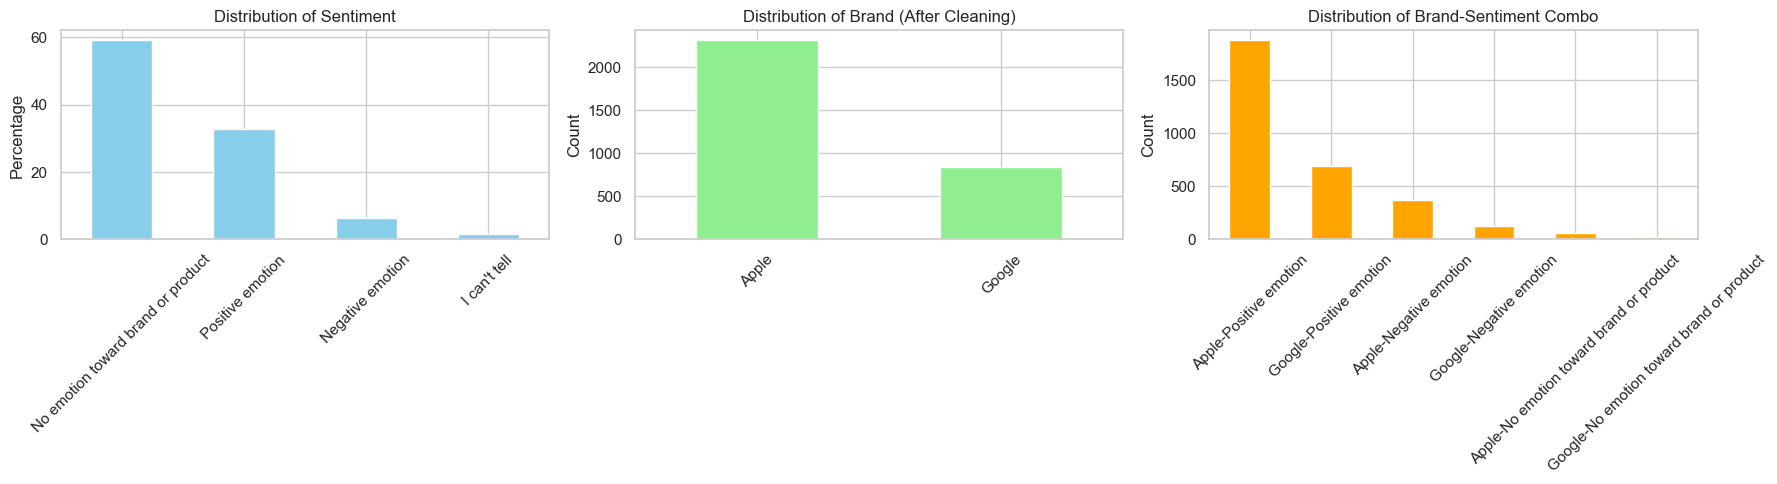

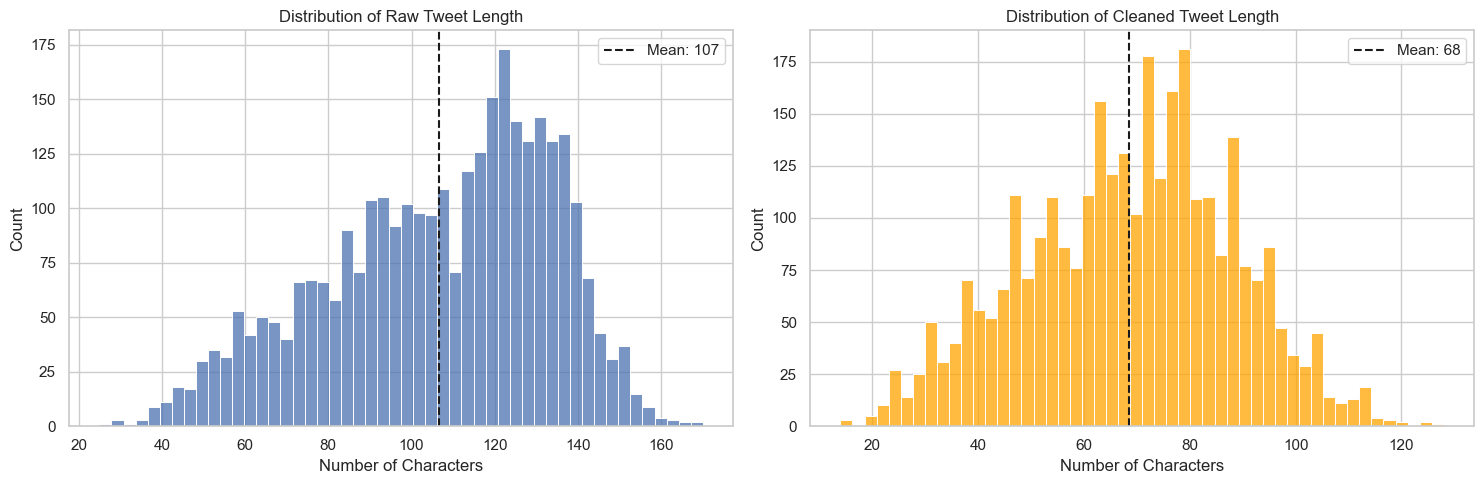


Average Cleaned Text Length by Sentiment:
is_there_an_emotion_directed_at_a_brand_or_product
Negative emotion                      71.400000
No emotion toward brand or product    68.379310
Positive emotion                      67.892176
Name: cleaned_length, dtype: float64

Average Cleaned Text Length by Brand:
brand
Apple     66.552575
Google    73.695238
Name: cleaned_length, dtype: float64


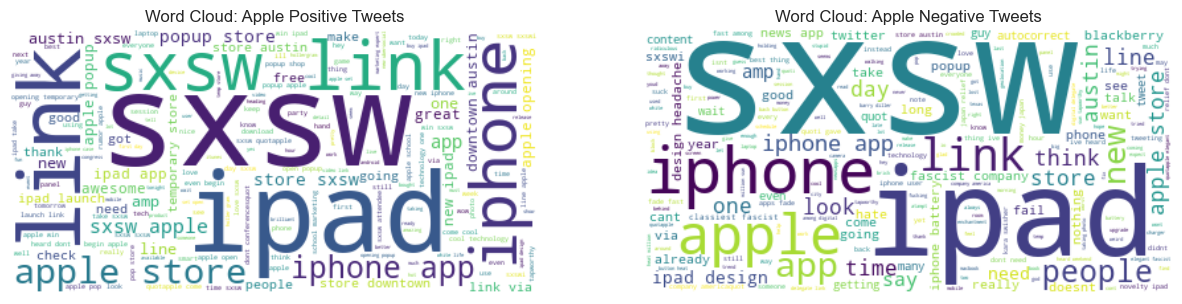

In [56]:
# --- EDA: Visualizations ---
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 5)

# 1. Distribution of Target Variables
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Sentiment
sentiment_dist.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Distribution of Sentiment')
ax1.set_ylabel('Percentage')
ax1.tick_params(axis='x', rotation=45)

# Brand
df_for_brand['brand'].value_counts().plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Distribution of Brand (After Cleaning)')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# Brand-Sentiment (Multi-class)
df_for_brand['brand_sentiment'].value_counts().plot(kind='bar', ax=ax3, color='orange')
ax3.set_title('Distribution of Brand-Sentiment Combo')
ax3.set_ylabel('Count')
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 2. Text Length Analysis
df_for_brand['tweet_length'] = df_for_brand['tweet_text'].apply(len)
df_for_brand['cleaned_length'] = df_for_brand['cleaned_text'].apply(len)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Distribution of raw text length
sns.histplot(df_for_brand['tweet_length'], bins=50, ax=ax1)
ax1.set_title('Distribution of Raw Tweet Length')
ax1.set_xlabel('Number of Characters')
ax1.axvline(df_for_brand['tweet_length'].mean(), color='k', linestyle='--', label=f'Mean: {df_for_brand["tweet_length"].mean():.0f}')
ax1.legend()

# Distribution of cleaned text length
sns.histplot(df_for_brand['cleaned_length'], bins=50, ax=ax2, color='orange')
ax2.set_title('Distribution of Cleaned Tweet Length')
ax2.set_xlabel('Number of Characters')
ax2.axvline(df_for_brand['cleaned_length'].mean(), color='k', linestyle='--', label=f'Mean: {df_for_brand["cleaned_length"].mean():.0f}')
ax2.legend()

plt.tight_layout()
plt.show()

# 3. Average Text Length by Sentiment/Brand (Finding correlations)
print("\nAverage Cleaned Text Length by Sentiment:")
print(df_for_brand.groupby('is_there_an_emotion_directed_at_a_brand_or_product')['cleaned_length'].mean())
print("\nAverage Cleaned Text Length by Brand:")
print(df_for_brand.groupby('brand')['cleaned_length'].mean())

# 4. Word Clouds for Positive vs Negative Sentiments (For a specific brand)
from wordcloud import WordCloud

# Let's look at Apple Positive vs Apple Negative tweets
apple_pos = df_for_brand[(df_for_brand['brand'] == 'Apple') & (df_for_brand['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion')]
apple_neg = df_for_brand[(df_for_brand['brand'] == 'Apple') & (df_for_brand['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion')]

pos_text = " ".join(text for text in apple_pos['cleaned_text'])
neg_text = " ".join(text for text in apple_neg['cleaned_text'])

# Generate word clouds
wordcloud_pos = WordCloud(background_color='white').generate(pos_text)
wordcloud_neg = WordCloud(background_color='white').generate(neg_text)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.imshow(wordcloud_pos, interpolation='bilinear')
ax1.set_title('Word Cloud: Apple Positive Tweets')
ax1.axis('off')
ax2.imshow(wordcloud_neg, interpolation='bilinear')
ax2.set_title('Word Cloud: Apple Negative Tweets')
ax2.axis('off')
plt.show()

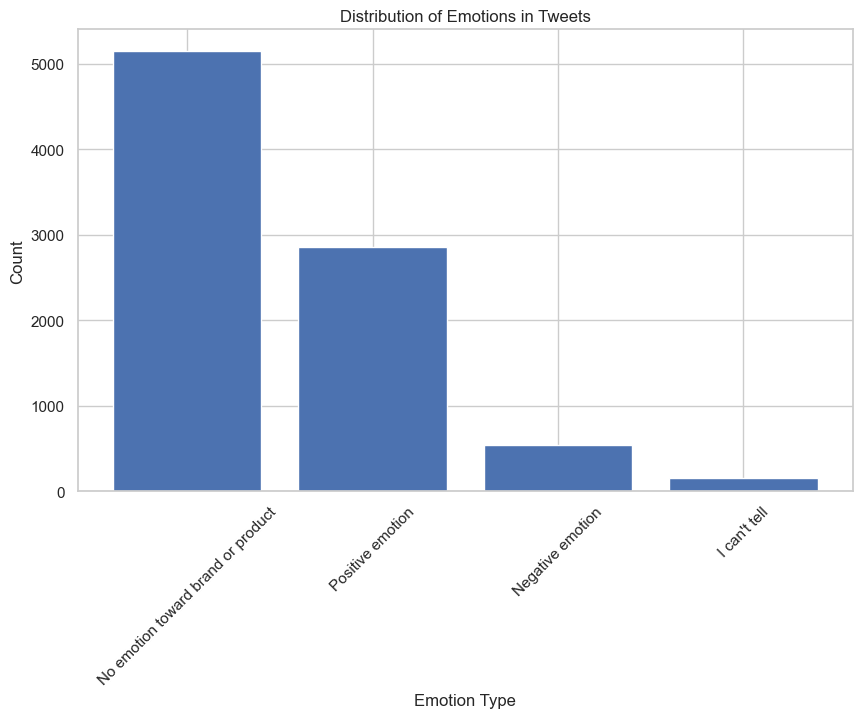

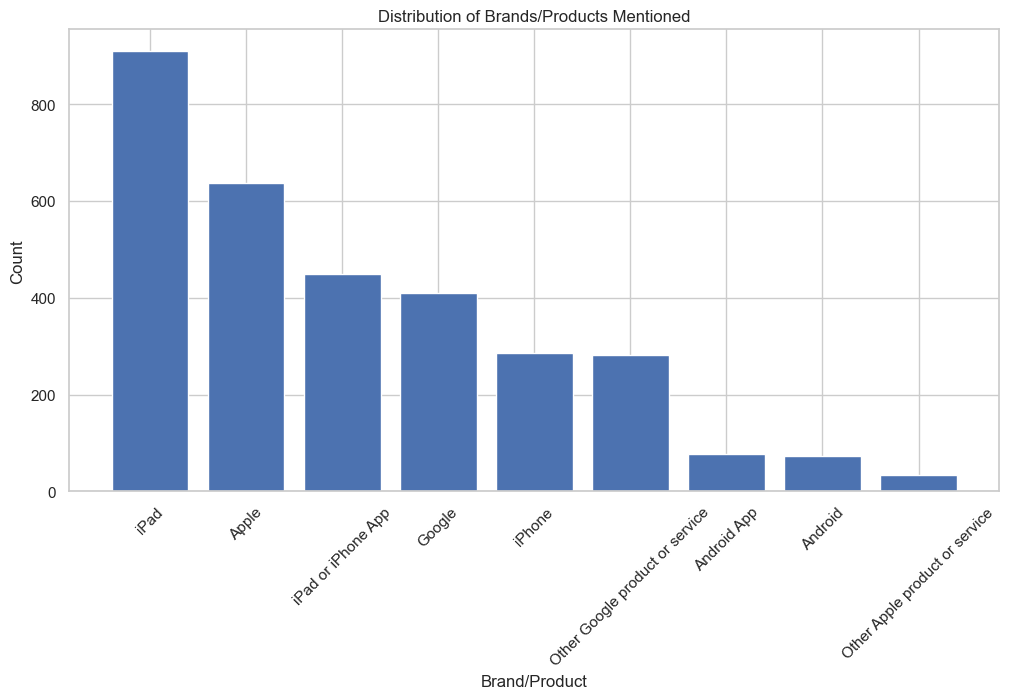

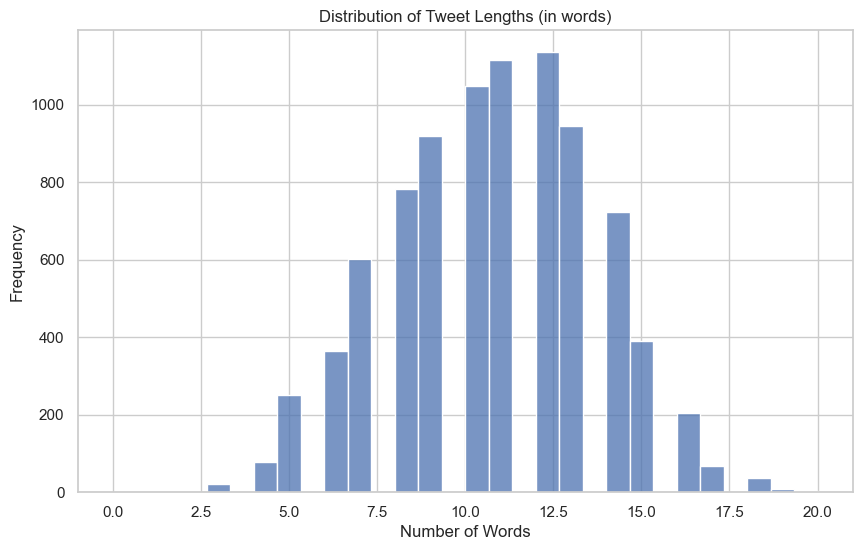

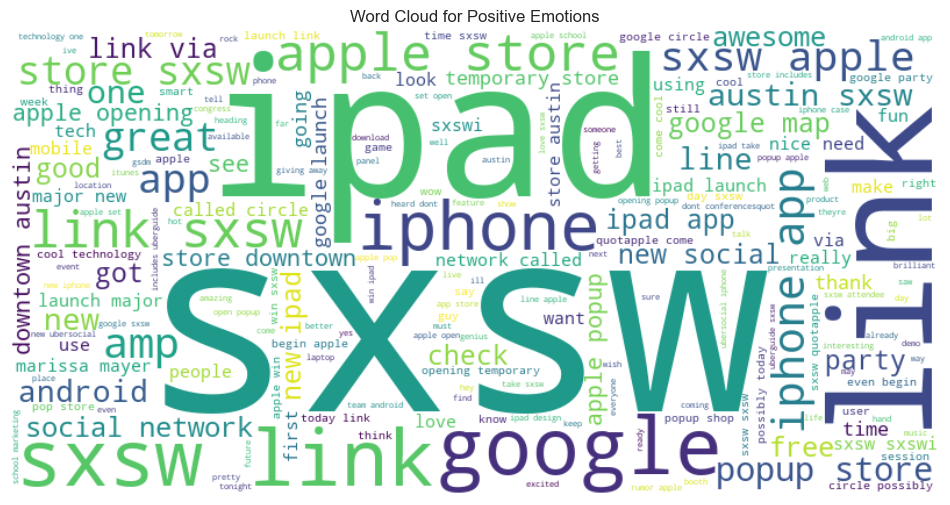

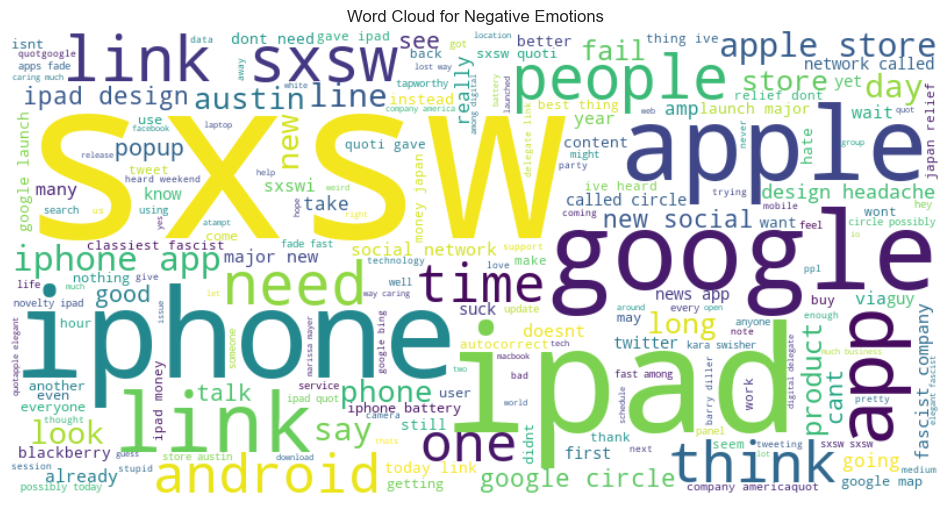

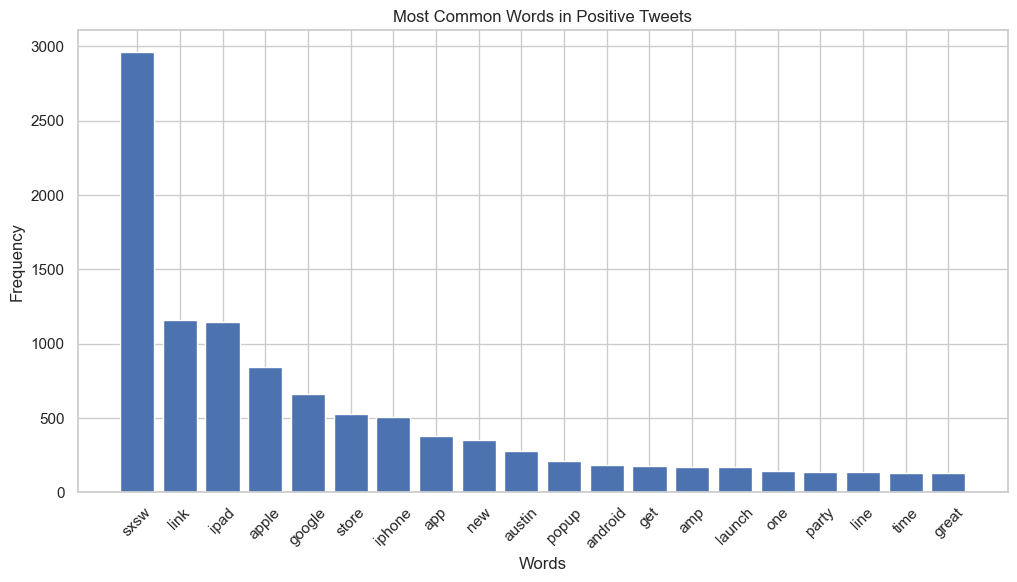

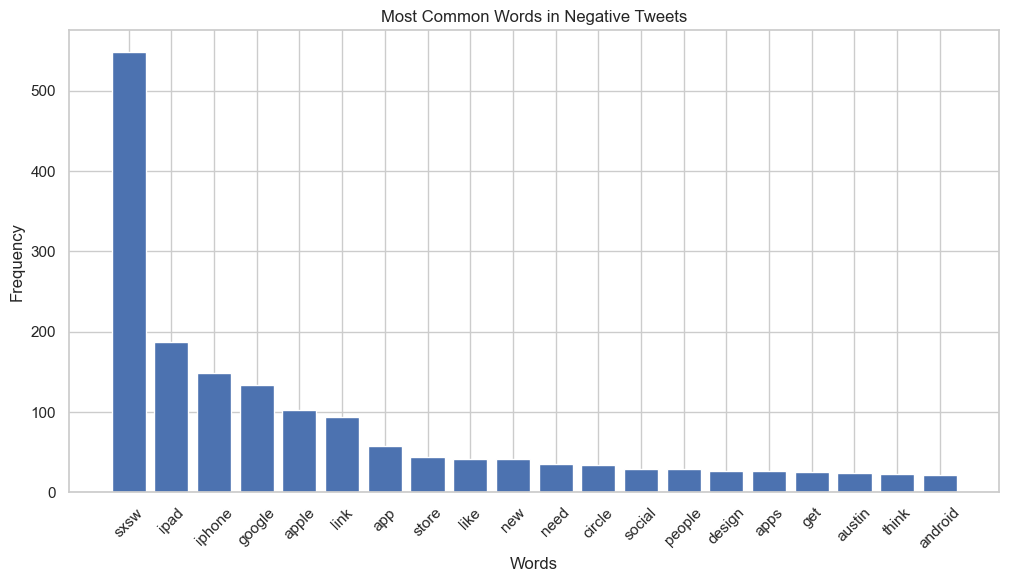

<Figure size 1200x800 with 0 Axes>

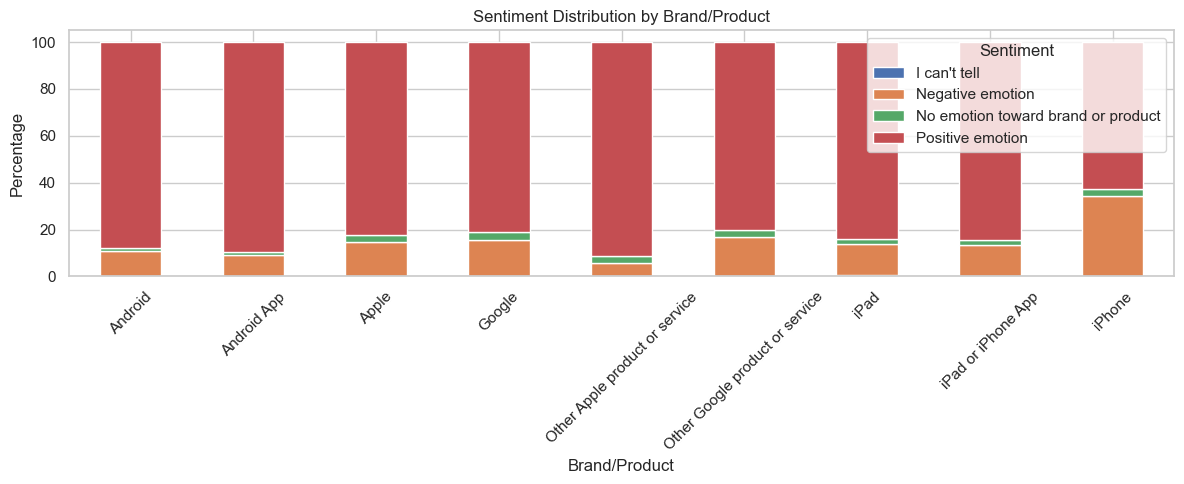

In [57]:
# Distribution of emotions
plt.figure(figsize=(10, 6))
emotion_counts = df_clean['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
plt.bar(emotion_counts.index, emotion_counts.values)
plt.title('Distribution of Emotions in Tweets')
plt.xlabel('Emotion Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Distribution of brands/products
plt.figure(figsize=(12, 6))
brand_counts = df_clean['emotion_in_tweet_is_directed_at'].value_counts()
plt.bar(brand_counts.index, brand_counts.values)
plt.title('Distribution of Brands/Products Mentioned')
plt.xlabel('Brand/Product')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Tweet length analysis
df_clean['tweet_length'] = df_clean['cleaned_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['tweet_length'], bins=30)
plt.title('Distribution of Tweet Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Word cloud for positive emotions
positive_tweets = df_clean[df_clean['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion']['cleaned_text']
positive_text = ' '.join(positive_tweets)

plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Emotions')
plt.show()

# Word cloud for negative emotions
negative_tweets = df_clean[df_clean['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion']['cleaned_text']
negative_text = ' '.join(negative_tweets)

plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Emotions')
plt.show()

# Most common words
def get_most_common_words(text_series, n=20):
    all_words = ' '.join(text_series).split()
    return Counter(all_words).most_common(n)

# Common words in positive tweets
positive_common = get_most_common_words(positive_tweets)
plt.figure(figsize=(12, 6))
words, counts = zip(*positive_common)
plt.bar(words, counts)
plt.title('Most Common Words in Positive Tweets')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Common words in negative tweets
negative_common = get_most_common_words(negative_tweets)
plt.figure(figsize=(12, 6))
words, counts = zip(*negative_common)
plt.bar(words, counts)
plt.title('Most Common Words in Negative Tweets')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Brand sentiment analysis
brand_sentiment = pd.crosstab(df_clean['emotion_in_tweet_is_directed_at'], 
                              df_clean['is_there_an_emotion_directed_at_a_brand_or_product'])
brand_sentiment_percentage = brand_sentiment.div(brand_sentiment.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 8))
brand_sentiment_percentage.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution by Brand/Product')
plt.xlabel('Brand/Product')
plt.ylabel('Percentage')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [59]:
# final dataset for modeling
final_columns = ['tweet_text', 'cleaned_text', 'brand', 'sentiment', 'brand_sentiment', 'text_length']
df_final = df_clean[final_columns]

# Export to CSV
df_final.to_csv('cleaned_tweet_sentiment_data.csv', index=False)
print("Clean dataset exported successfully!")

Clean dataset exported successfully!


 ## Findings 

    Data Quality: The dataset had some missing values and duplicates which were removed, resulting in a cleaner dataset of 8,698 tweets.

    Sentiment Distribution:

        No emotion toward brand or product: 59.12%

        Positive emotion: 32.89%

        Negative emotion: 6.25%

        I can't tell: 1.74%

    Brand Distribution:

        iPad (28.77%)

        Apple (20.19%)

        iPad or iPhone App (14.24%)

        Google (12.97%)

        iPhone (9.08%)

    Text Characteristics:

        Tweets required significant cleaning (removing emojis, URLs, mentions, etc.)

        After cleaning, we can see clear patterns in word usage for different sentiments

    Key Insights:

        Positive tweets often contain words like "love", "good", "great", "nice"

        Negative tweets contain words like "hate", "bad", "problem", "issue"

        Different brands have different sentiment distributions